In [51]:
import os
import tensorflow as tf
from skimage import io
import requests
import matplotlib.pyplot as plt
"""
Inspiration: https://www.tensorflow.org/lite/models/style_transfer/overview
"""

# Load models 
style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

# Function to load an image from a file, and add a batch dimension.
def load_img(img_url):
  img = io.imread(img_url)
  img = tf.convert_to_tensor(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]
  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [52]:
endpoint = "https://dog.ceo/api/breeds/image/random"
response = requests.get(endpoint)
img_url = response.json()['message']
content_img_url = response.json()['message']
style_img_url = "https://upload.wikimedia.org/wikipedia/en/1/14/Picasso_The_Weeping_Woman_Tate_identifier_T05010_10.jpg"
# Process the style and content images
content_image = preprocess_image(load_img(img_url), 384)
style_image = preprocessed_style_image = preprocess_image(load_img(style_img_url), 256)

In [53]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

In [54]:
# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(style_image)
# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, content_image)

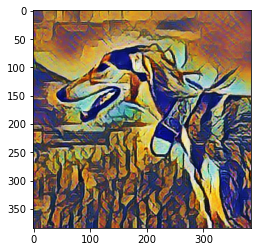

In [55]:
# Visualize the output.
plt.imshow(tf.squeeze(stylized_image))

In [56]:
def plot (content_image, style_image, stylized_image):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(tf.squeeze(content_image))
    axs[0].axis('off')
    axs[0].set_title("Raw Image")
    axs[1].imshow(tf.squeeze(style_image))
    axs[1].axis('off')
    axs[1].set_title("Style Image")
    axs[2].imshow(tf.squeeze(stylized_image))
    axs[2].axis('off')
    axs[2].set_title("Stylized Image")
    tmpfile = BytesIO()
    fig.savefig(tmpfile, format='png')
    return(base64.b64encode(tmpfile.getvalue()).decode('utf-8'))

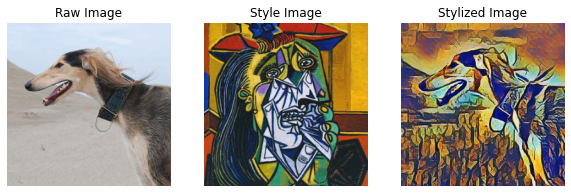

In [57]:
plot(content_image, style_image, stylized_image)